# Lecture 15 - Twitter Analysis

Use this notebook to perform some advanced analytics on Twitter data for your projects. 

Below is the overview of this notebook.

<ol type = 1>
    <li> User Tweets</li>
    <ol type = 1>
      <li> Top Retweeted Tweets</li>
      <li> Keyword vs Retweet Count</li>
      <li> Keyword vs Sentiment</li>
    </ol>
    <li> Keyword Tweets</li>
    <ol type = 1>
      <li> Tweet Rate</li>
      <li> Keyword Tweet Rate</li>
      <li> Interaction Network and Centralities</li>
      <li> Similarity Network and Communities</li>
    </ol>
</ol>

This notebook can be opened in Colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture15_TwitterAnalysis.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.




# Clones, installs, and imports


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (327/327), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 327 (delta 181), reused 222 (delta 79), pack-reused 0
Receiving objects: 100% (327/327), 32.46 MiB | 10.70 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Checking out files: 100% (43/43), done.


## Install Requirements 


In [2]:
!pip install -r requirements.txt


     |████████████████████████████████| 58 kB 2.7 MB/s 
     |████████████████████████████████| 3.8 MB 8.2 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 1.6 MB 31.3 MB/s 
     |████████████████████████████████| 67 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 40.0 MB/s 
     |████████████████████████████████| 895 kB 35.4 MB/s 
     |████████████████████████████████| 6.5 MB 7.9 MB/s 
     |████████████████████████████████| 1.1 MB 23.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=e2a805286a8080f81056703ecb6d830a60b1a1f7aa398b9af8be83292b8d4b14
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=c874d974161bd239c9297f1cf69269ef2d71cfd355da73f75da4ad995785107e
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a7

## Import Packages



In [64]:
from datetime import datetime, timedelta
import numpy as np
import sqlite3, sys, os
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import seaborn as sns
import codecs  #this let's us display tweets properly (emojis, etc.)
import regex as re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#helper code
from scripts.api import *
from scripts.create_graph import *
from scripts.communities import spectral_communities
from scripts.communities import umap_layout,network_thinner
import scripts.TextAnalysis as ta


pd.set_option("display.max_colwidth", None)


# User Tweets

This section will show some analysis you can do on a set of tweets obtained from the timelines of users.  We will use a set of tweets for which we already calculated the sentiment using a transformer (the tweets and sentiment are in a CSV file).

## Load User Tweets

In [156]:
df = pd.read_csv("data/lec_08_tweets_sentiment.csv")
ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.sample(n=2)

dataframe has 8628 tweets


,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,sentiment
7399,7397,2020-10-25T16:26:51.000Z,KingJames,💼 he was! Only the beginning. #JamesGang👑 https://t.co/nt0HsL0oty,en,6439.0,772.0,94830.0,653.0,1.320401e+18,23083404,1.320401e+18,NaN,None,3.062255
3167,3167,2020-10-14T20:35:29.000Z,BarackObama,".@JohnBrennan is one of the hardest-working, most patriotic public servants I’ve ever seen, and our country is better off for it. As president, he was one of my closest advisors and a great friend. And in his memoir, Undaunted, you’ll see why. I hope you’ll read it. https://t.co/d9txQZ8G81",en,5114.0,1759.0,42089.0,283.0,1.316478e+18,813286,1.316478e+18,NaN,None,4.013643


## Load User Profiles

In [157]:
fname_db = "data/lecture_04"  #database filenmae
df_profile = DB.fetch(table_name='users', path=fname_db)

df_profile

,created_at,name,screen_name,description,id,location,followers_count,following_count,listed_count,tweet_count
0,2009-06-02T20:12:29.000Z,Elon Musk,elonmusk,,44196397,None,72066929,107,85727,16708
1,2013-12-08T08:16:34.000Z,Dogecoin,dogecoin,"Dogecoin is an open source peer-to-peer cryptocurrency, favored by shibas worldwide. Elon Musk thinks we're pretty cool. [RTs are not endorsements]",2235729541,the moon,2961889,12,5556,882
2,2010-07-22T23:00:05.000Z,ye,kanyewest,,169686021,None,30612283,209,43413,1911
3,2009-03-19T19:21:56.000Z,Kim Kardashian West,KimKardashian,@KKWFRAGRANCE @SKIMS,25365536,,71044829,124,72664,35169
4,2011-11-10T20:13:01.000Z,Michelle Obama,MichelleObama,"Girl from the South Side and former First Lady. Wife, mother, dog lover. Always hugger-in-chief. #IAmBecoming",409486555,"Washington, DC",21361348,16,27577,1861
5,2007-03-05T22:08:25.000Z,Barack Obama,BarackObama,"Dad, husband, President, citizen.",813286,"Washington, DC",130668615,586779,222140,16374
6,2009-06-04T17:41:41.000Z,J BALVIN,JBALVIN,Ser Humano,44670915,None,10374829,537,7289,31684
7,2018-11-05T20:25:06.000Z,☀️🌊,sanbenito,"un día bien, al otro mal...",1059542139737128960,None,3679386,1,922,1224
8,2010-04-28T22:38:40.000Z,Alexandria Ocasio-Cortez,AOC,"US Representative,NY-14 (BX & Queens). In a modern, moral, & wealthy society, no American should be too poor to live. 💯% People-Funded, no lobbyist💰. She/her.",138203134,"Bronx + Queens, NYC",12880856,3558,24936,13420
9,2009-03-06T16:25:53.000Z,LeBron James,KingJames,EST. AKRON - ST.V/M Class of '03 https://t.co/TrZZrgR90t #IPROMISE,23083404,Amongst La Familia!,50723220,182,45416,8240


## Ratio of Retweets to Followers

The ratio of mean retweet count to followers count tells you what fraction of a user's followers retweet their content.  This can be a measure of how engaged a user's followers are.

In [174]:
df_r = df.groupby(by = 'screen_name').mean()
df_r.reset_index(inplace = True)
df_profile['retweet_count'] = df_r.retweet_count
df_profile['retweet_followers_ratio'] = df_profile.retweet_count/df_profile.followers_count
df_profile.head(n=3)

,created_at,name,screen_name,description,id,location,followers_count,following_count,listed_count,tweet_count,retweet_count,retweet_followers_ratio
0,2009-06-02T20:12:29.000Z,Elon Musk,elonmusk,,44196397,None,72066929,107,85727,16708,113.000000,0.000002
1,2013-12-08T08:16:34.000Z,Dogecoin,dogecoin,"Dogecoin is an open source peer-to-peer cryptocurrency, favored by shibas worldwide. Elon Musk thinks we're pretty cool. [RTs are not endorsements]",2235729541,the moon,2961889,12,5556,882,4040.399454,0.001364
2,2010-07-22T23:00:05.000Z,ye,kanyewest,,169686021,None,30612283,209,43413,1911,19865.451565,0.000649


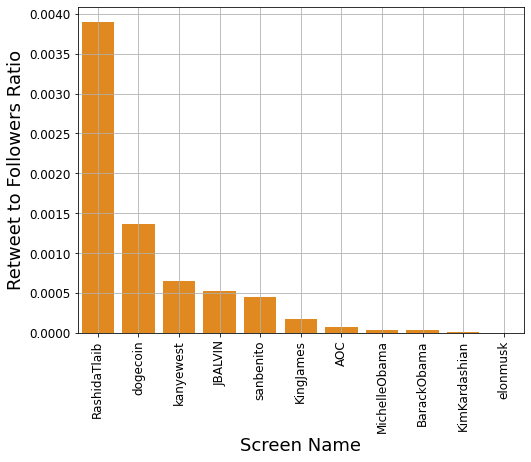

In [176]:
fig = plt.figure(figsize = (8,6))
ax = sns.barplot(data = df_profile.sort_values(by = 'retweet_followers_ratio', ascending = False), 
                x = 'screen_name', y = 'retweet_followers_ratio',color = 'darkorange')
plt.ylabel("Retweet to Followers Ratio",fontsize = 18)
plt.xlabel("Screen Name",fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()
plt.show()


## Top Retweeted Tweets

In [160]:
for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name].copy()
  df_u = df_u[df_u.text.str.contains("RT @", case=False)==False] #remove any retweets
  df_u.sort_values(by = 'retweet_count', ascending = False, inplace = True)
  display(df_u[['screen_name','retweet_count','text']].head(n=3))

,screen_name,retweet_count,text
13,elonmusk,114819.0,"If you scare people enough, they will demand removal of freedom. This is the path to tyranny."
49,elonmusk,92777.0,https://t.co/ReDlSVLcl7
45,elonmusk,83591.0,https://t.co/iLfCWdi0Lb


,screen_name,retweet_count,text
164,dogecoin,3995.0,"A word of warning: Do not send coins to people claiming they will double, triple or otherwise multiply your coins. Those are scams. We can not return your money to you either. Please watch out and remember if something sounds to good to be true, it likely is."
217,dogecoin,3407.0,Not even mad 😂 https://t.co/zOYbaJHqSE
172,dogecoin,3326.0,"If someone asks you to send money before you can receive money, you're likely dealing with a scam. Please stay safe, shibes, and carefully research sites and services you have not used before. #Dogecoin #DoOnlyGoodEveryday"


,screen_name,retweet_count,text
986,kanyewest,252456.0,"We must now realize the promise of America by trusting God, unifying our vision and building our future. I am running for president of the United States 🇺🇸! #2020VISION"
554,kanyewest,158412.0,Trust me ... I WONT STOP https://t.co/RmVkqrSa4F
1007,kanyewest,116863.0,"Kobe, We love you brother\n\nWe’re praying for your family and appreciate the life you’ve lived and all the inspiration you gave https://t.co/pxbgLOOmpY"


,screen_name,retweet_count,text
1467,KimKardashian,22614.0,#DONDA https://t.co/55tmitK7ha
1355,KimKardashian,21568.0,Megan Fox and Kourtney Kardashian for Skims https://t.co/rs8qx8WHo1
1319,KimKardashian,20957.0,KRAVIS FOREVER 💍 @kourtneykardash @travisbarker https://t.co/gymsssnMFr


,screen_name,retweet_count,text
2640,MichelleObama,92631.0,"Like so many of you, I’m pained by these recent tragedies. And I’m exhausted by a heartbreak that never seems to stop. Right now it’s George, Breonna, and Ahmaud. Before that it was Eric, Sandra, and Michael. It just goes on, and on, and on. https://t.co/lFWEtTzVT8"
2136,MichelleObama,77665.0,"Happy New Year from me and my boo! 🎉🥳 Wishing you all a year filled with happiness, love, and good health. https://t.co/FRR0DDZjw9"
2399,MichelleObama,56781.0,"Van, thank you for expressing the sorrow and relief that we all feel. My hope is that those who hoped for a different outcome will take a moment to empathize with the pain so many of us have felt over the past four years. https://t.co/eqL1szT1Iz"


,screen_name,retweet_count,text
3411,BarackObama,616378.0,Kobe was a legend on the court and just getting started in what would have been just as meaningful a second act. To lose Gianna is even more heartbreaking to us as parents. Michelle and I send love and prayers to Vanessa and the entire Bryant family on an unthinkable day.
3316,BarackObama,439246.0,My statement on the death of George Floyd: https://t.co/Hg1k9JHT6R
3413,BarackObama,356649.0,"In every scene, you are my star, @MichelleObama! Happy birthday, baby! https://t.co/hgMBhHasBj"


,screen_name,retweet_count,text
4376,JBALVIN,19102.0,"Me critican sin ni siquiera tratar de enseñarme, ¿así cómo aprendo?"
4305,JBALVIN,18312.0,Ser leal y agradecido.
3441,JBALVIN,15467.0,So excited for the launch of my friend @plansartstudio and his team for the incredible project @LilHeroesNFT ⚡⚡ I’m happy to giveaway 1 FREE NFT and 10 Whitelist spots to you! To participate 👇\n\n1- Like and Retweet this post \n2- Follow @jbalvin &amp; @LilHeroesNFT \n3- Tag 2 friends https://t.co/NQLWRbv77x


,screen_name,retweet_count,text


,screen_name,retweet_count,text
3593,2259,113.0,284


,screen_name,retweet_count,text
4695,sanbenito,158295.0,RT SI QUIERES MÚSICA NUEVA
5155,sanbenito,112757.0,"En vez de felicitarla hoy, respétela. Respeta sus capacidades, sus virtudes, sus defectos, respeta su espacio y su tiempo, sus deseos, sus metas, sus sueños, sus luchas, respeta su cuerpo y cada una de sus decisiones. 🖤 Hoy y todos los días, feliz día de respetar a la mujer."
5276,sanbenito,108964.0,https://t.co/PtS53tGcCP


,screen_name,retweet_count,text
6101,AOC,69783.0,Shout out to all the legislators going out on dinner dates with Exxon lobbyists so they can say a Green New Deal is too expensive 👍🏽 https://t.co/zlQE7LGfPL
6298,AOC,66080.0,"This is happening with the support of the United States.\n\nI don’t care how any spokesperson tries to spin this. The US vetoed the UN call for ceasefire.\n\nIf the Biden admin can’t stand up to an ally, who can it stand up to?\n\nHow can they credibly claim to stand for human rights? https://t.co/bXY99O3Wqp"
6297,AOC,55330.0,Apartheid states aren’t democracies.


,screen_name,retweet_count,text
7484,KingJames,262573.0,FUCK THIS MAN!!!! WE DEMAND CHANGE. SICK OF IT
7345,KingJames,245157.0,https://t.co/J40qxvNc82
7147,KingJames,116390.0,IM 36!!!!! IM 36!!!! STOP THROWING THE BALL 😡😡😡🤣🤣🤣🤣🤣💀 https://t.co/KkU32nQVKU


,screen_name,retweet_count,text
8395,RashidaTlaib,12924.0,"Suppose your child did not want to go fight countless and endless shadow wars across the globe, at this time, but you’re paying taxes to fund all of that. You may not be happy about it! https://t.co/jlJ5uEU9F9"
7662,RashidaTlaib,9132.0,"Magically found $768,000,000,000 for a defense budget, but the same folks can't fully fund the $45- $60 billion needed to remove lead service lines in our country."
7806,RashidaTlaib,5055.0,I am not going to sell out my district for a bill that was written by the fossil fuel industry and championed by two Dem senators who bow down to Big Pharma &amp; corporate polluters.


## Keyword vs Retweet Count Per User

In [161]:
keywords = ['love','trump','hate','biden']

elonmusk
	1 tweets contain love
	0 tweets contain trump
	0 tweets contain hate
	2 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


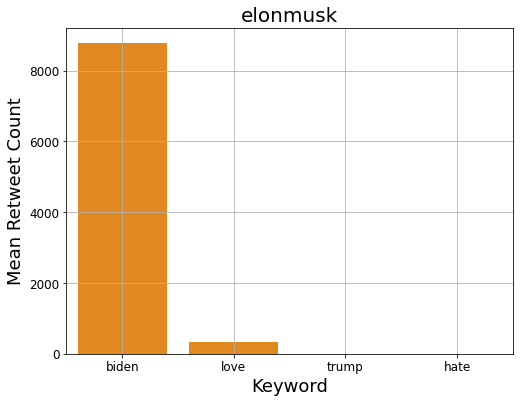

dogecoin
	4 tweets contain love
	0 tweets contain trump
	1 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


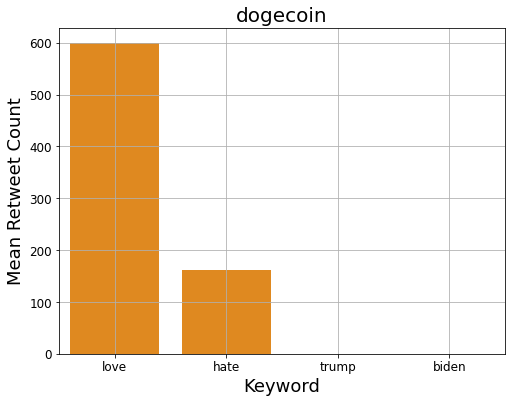

kanyewest
	27 tweets contain love
	3 tweets contain trump
	1 tweets contain hate
	5 tweets contain biden


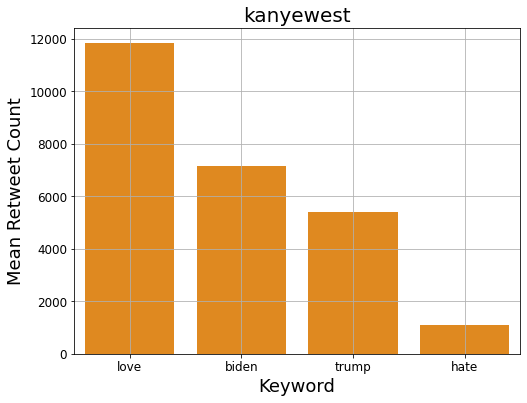

KimKardashian
	94 tweets contain love
	0 tweets contain trump
	2 tweets contain hate
	1 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


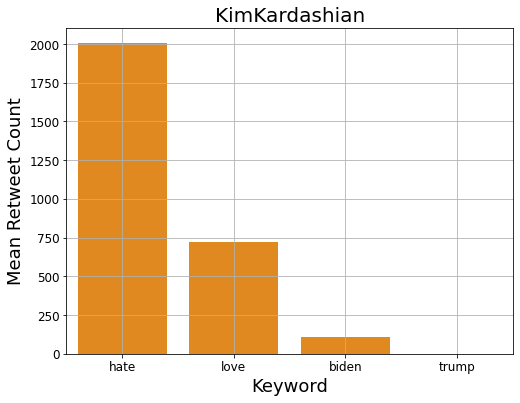

MichelleObama
	93 tweets contain love
	0 tweets contain trump
	3 tweets contain hate
	25 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


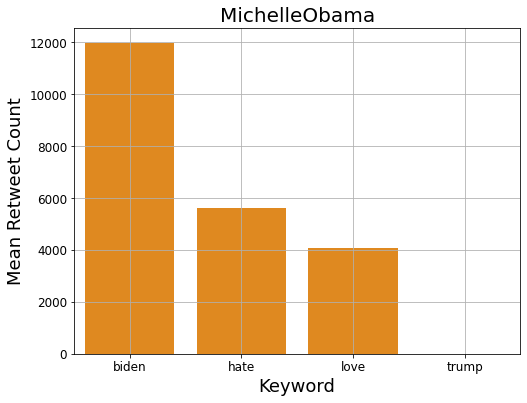

BarackObama
	44 tweets contain love
	1 tweets contain trump
	3 tweets contain hate
	58 tweets contain biden


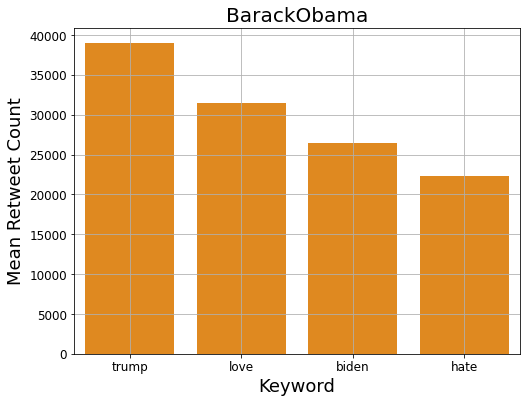

JBALVIN
	13 tweets contain love
	0 tweets contain trump
	1 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


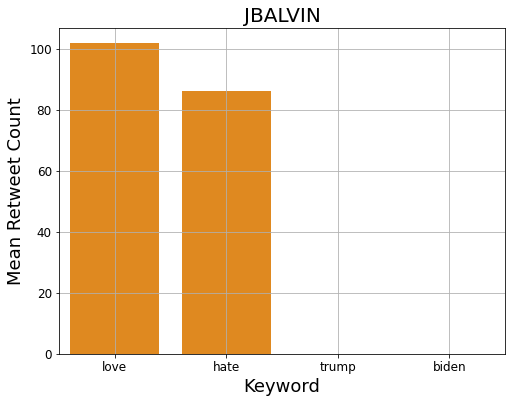

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
	0 tweets contain love
	0 tweets contain trump
	0 tweets contain hate
	0 tweets contain biden


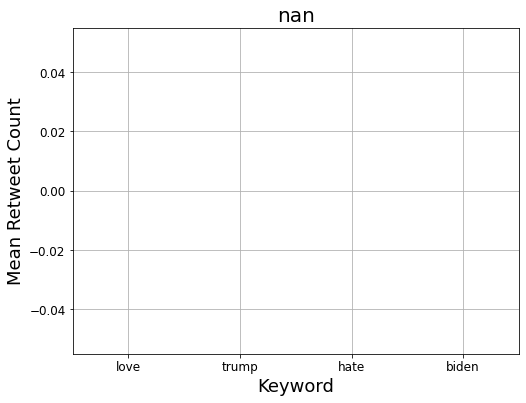

2259
	0 tweets contain love
	0 tweets contain trump
	0 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


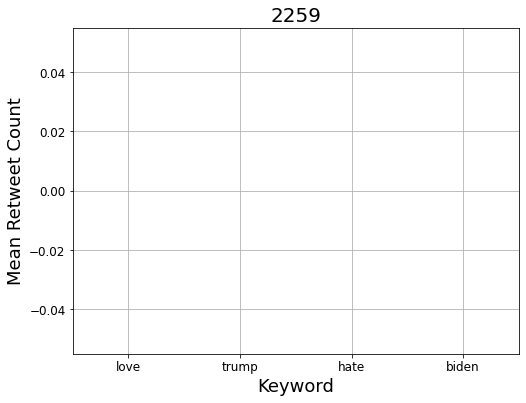

sanbenito
	3 tweets contain love
	0 tweets contain trump
	5 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


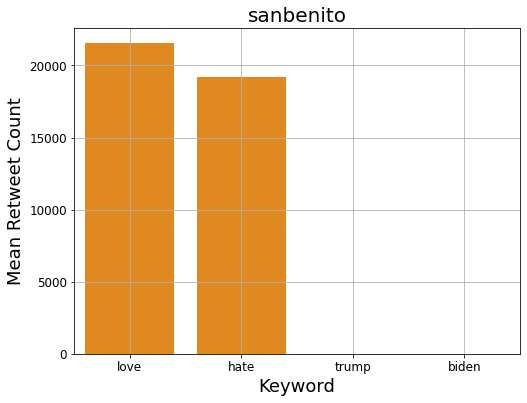

AOC
	15 tweets contain love
	11 tweets contain trump
	3 tweets contain hate
	30 tweets contain biden


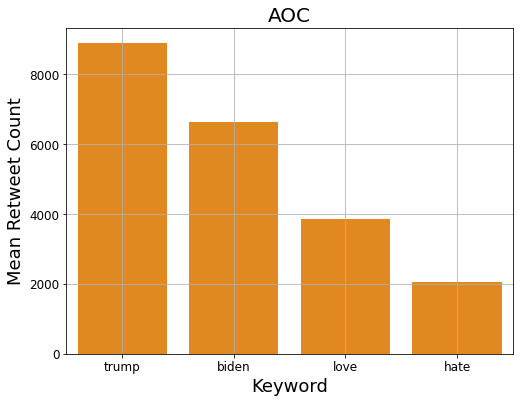

KingJames
	72 tweets contain love
	0 tweets contain trump
	9 tweets contain hate
	1 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


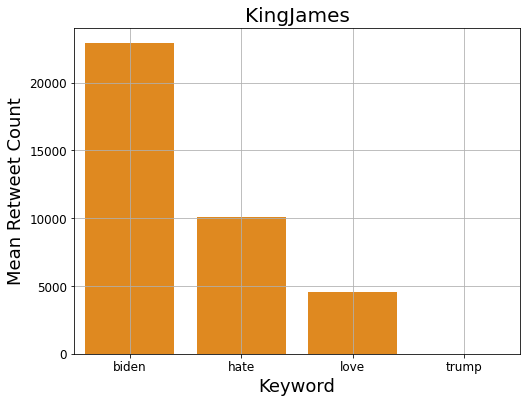

RashidaTlaib
	40 tweets contain love
	2 tweets contain trump
	12 tweets contain hate
	15 tweets contain biden


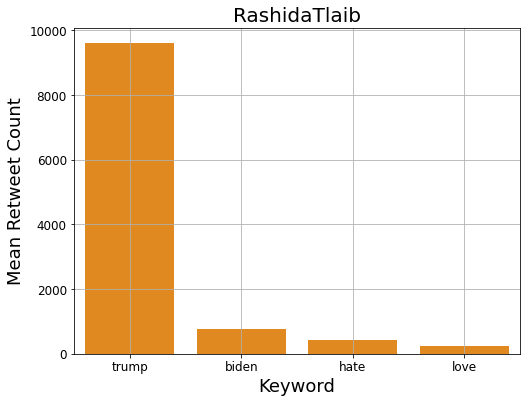

In [162]:
for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name]
  keyword_rt = []
  print(screen_name)
  for keyword in keywords:
      X = df_u.retweet_count[df_u.text.str.contains(keyword, case=False)==True].dropna().tolist()
      keyword_rt.append(np.mean(X))
      
      print(f"\t{len(X)} tweets contain {keyword}")

  df_plot = pd.DataFrame({'keyword':keywords, 'retweet_count':keyword_rt})
  fig = plt.figure(figsize = (8,6))
  ax = sns.barplot(data = df_plot.sort_values(by = 'retweet_count', ascending = False), 
                  x = 'keyword', y = 'retweet_count',color = 'darkorange')
  plt.ylabel("Mean Retweet Count",fontsize = 18)
  plt.xlabel("Keyword",fontsize = 18)
  plt.title(screen_name,fontsize = 20)
  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.grid()
  plt.show()

## Keyword vs Sentiment Per User

In [163]:
keywords = ['love','trump','hate','biden']

elonmusk
	1 tweets contain love
	0 tweets contain trump
	0 tweets contain hate
	2 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


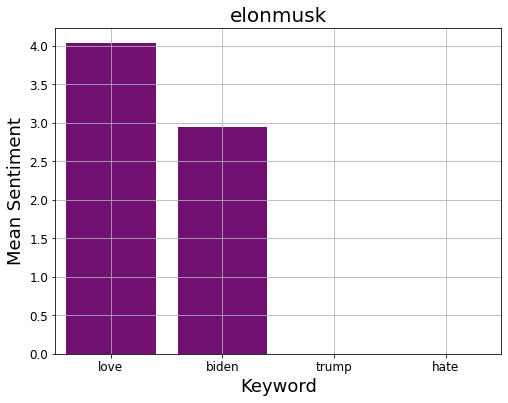

dogecoin
	4 tweets contain love
	0 tweets contain trump
	1 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


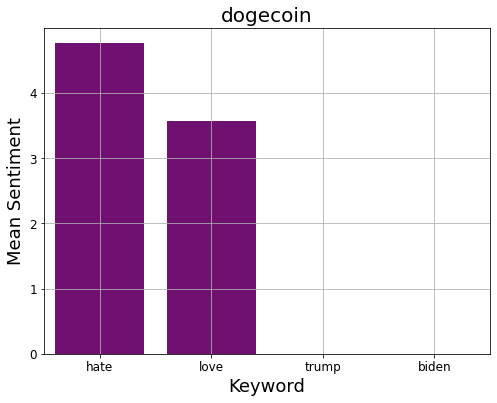

kanyewest
	27 tweets contain love
	3 tweets contain trump
	1 tweets contain hate
	5 tweets contain biden


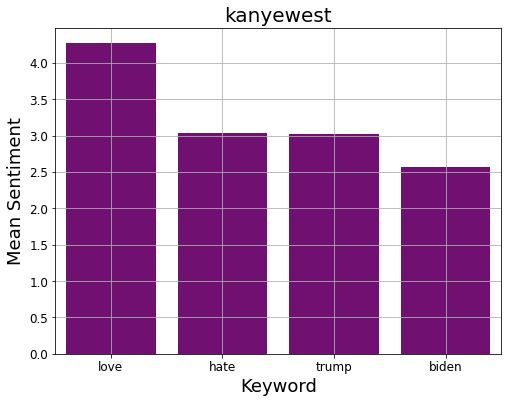

KimKardashian
	94 tweets contain love
	0 tweets contain trump
	2 tweets contain hate
	1 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


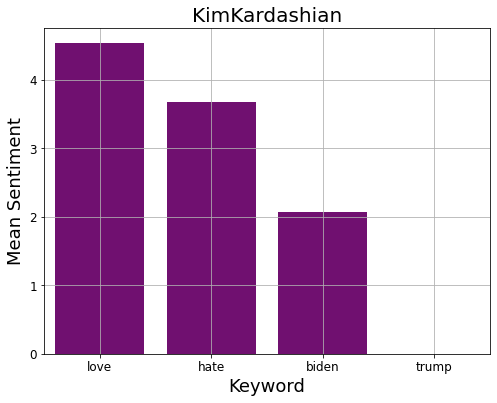

MichelleObama
	93 tweets contain love
	0 tweets contain trump
	3 tweets contain hate
	25 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


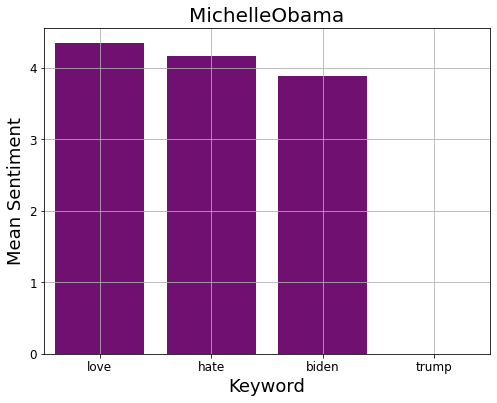

BarackObama
	44 tweets contain love
	1 tweets contain trump
	3 tweets contain hate
	58 tweets contain biden


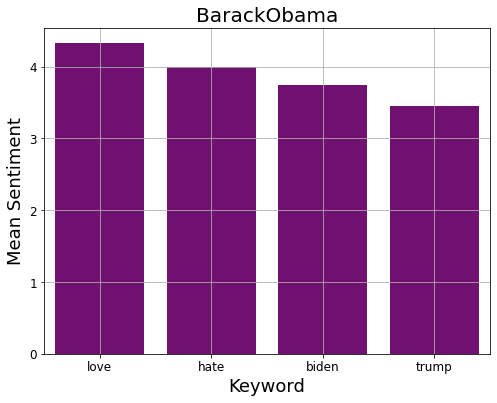

JBALVIN
	13 tweets contain love
	0 tweets contain trump
	1 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


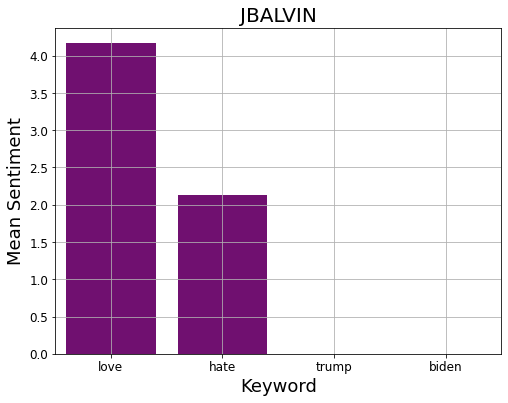

nan
	0 tweets contain love
	0 tweets contain trump
	0 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


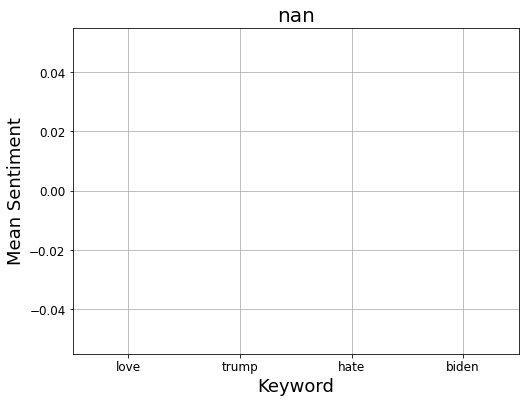

2259
	0 tweets contain love
	0 tweets contain trump
	0 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


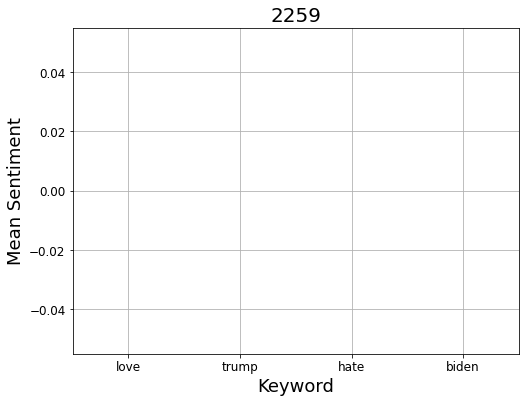

sanbenito
	3 tweets contain love
	0 tweets contain trump
	5 tweets contain hate
	0 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


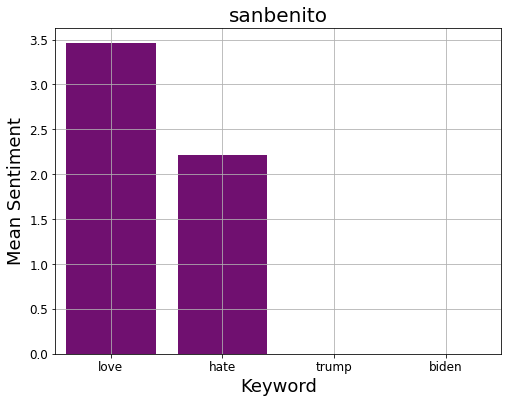

AOC
	15 tweets contain love
	11 tweets contain trump
	3 tweets contain hate
	30 tweets contain biden


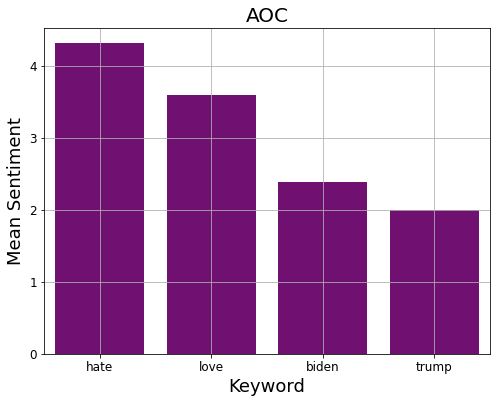

KingJames
	72 tweets contain love
	0 tweets contain trump
	9 tweets contain hate
	1 tweets contain biden


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


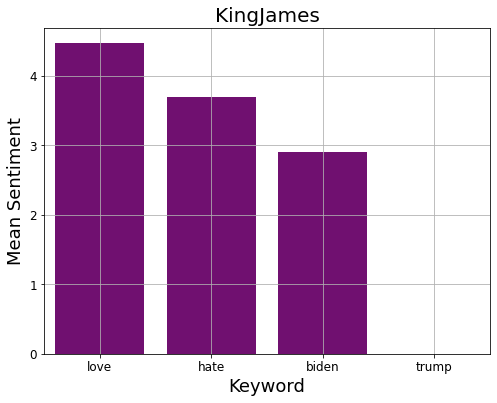

RashidaTlaib
	40 tweets contain love
	2 tweets contain trump
	12 tweets contain hate
	15 tweets contain biden


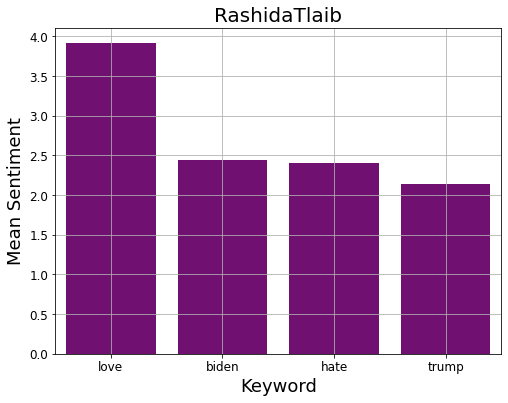

In [165]:
for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name]
  keyword_sentiments = []
  print(screen_name)
  for keyword in keywords:
      X = df_u.sentiment[df_u.text.str.contains(keyword, case=False)==True].dropna().tolist()
      keyword_sentiments.append(np.mean(X))
      
      print(f"\t{len(X)} tweets contain {keyword}")

  df_plot = pd.DataFrame({'keyword':keywords, 'sentiment':keyword_sentiments})
  fig = plt.figure(figsize = (8,6))
  ax = sns.barplot(data = df_plot.sort_values(by = 'sentiment', ascending = False), 
                  x = 'keyword', y = 'sentiment',color = 'purple')
  plt.ylabel("Mean Sentiment",fontsize = 18)
  plt.xlabel("Keyword",fontsize = 18)
  plt.title(screen_name,fontsize = 20)
  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.grid()
  plt.show()

# Keyword Tweets

This section will show some analysis you can do on a set of tweets obtained by keyword search.

## Load Keyword Tweets

In [13]:
fname_db = "data/lecture_02"  #database filenmae
df = DB.fetch(table_name='keyword_tweets', path=fname_db)

print(f"{len(df)} keyword tweets")
df.sample(n=4)

4805 keyword tweets


,text
3378,Some recent Ape happening!\n\n#bayc #boredapeyachtclub #boredape #boredapeyc #nfts #nft #nftcollector #NFTCommunity #NFTcollectibles #NFTcollectible #NFTcollectables #nftcollectors #NFTartists #nftart\nhttps://t.co/ovsG5WC0HR
2479,Some recent Ape happening!\n\n#bayc #boredapeyachtclub #boredape #boredapeyc #nfts #nft #nftcollector #NFTCommunity #NFTcollectibles #NFTcollectible #NFTcollectables #nftcollectors #NFTartists #nftart\nhttps://t.co/TUFSKe9Ek8
2520,@Bitboy_Crypto 🥳#NFTGiveaway🥳\n\n🎁Giving away 1 Bored Ape Crypto Paint #NFT! \n\n1️⃣Follow @pioaru_g\n2️⃣❤️&amp; RT\n3️⃣Tag 2 Friends\n\n#NFTCommunity #NFTGiveaways #NFTs #nftcollectors #nftart #OpenSeaNFT \n#BoredApeYachtClub https://t.co/FogtJGYqml
4140,What do you think about this #nft? Follow and check my collection on opensea for more. ##nftartist #nftcollector #nftcommunity #opensea #boredapeyachtclub #blockchains #ethereum #artofinstagram #artist #artwork https://t.co/uNzrEL7SMx


## Add Clean Text Column

In [94]:
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
df = df[df.text_clean.str.len() >0]  #remove cleaned tweets of lenght 0


## Add Created At Datetime Column and Sort

In [16]:
format = "%Y-%m-%d %H:%M:%S"
df['created_at_datetime'] = pd.to_datetime(df['created_at'],format=format).dt.tz_localize(None)
df.sort_values(by = 'created_at_datetime', inplace = True, ascending = True)

#define initial and final time variables (for plot axis limits)
ti = df.created_at_datetime.head(n=1).values[0]
tf = df.created_at_datetime.tail(n=1).values[0]

print(f"Head: {ti}")
print(f"Tail: {tf}")

Head: 2022-01-01T00:00:18.000000000
Tail: 2022-01-07T23:58:24.000000000


## Tweet Rate

In [17]:
df['tweet_indicator'] = np.ones(len(df))
df['rate_1D'] = df.rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']


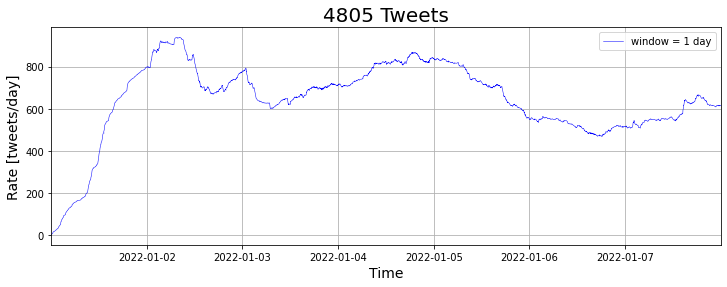

In [18]:
fig = plt.figure(figsize = (12,4))
sns.lineplot(data = df, x = 'created_at_datetime',y = 'rate_1D',
             label = 'window = 1 day',linewidth = .5,color = 'blue')


plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
plt.xlim(ti,tf)
#plt.ylim([0,30])
plt.title(f"{len(df)} Tweets",fontsize = 20)

plt.legend()
plt.show()

## Keyword Frequency

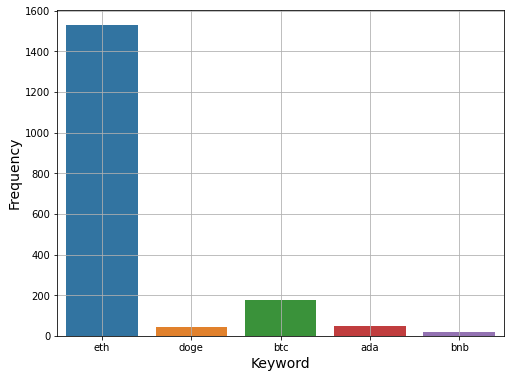

In [23]:
keywords = ['eth','doge','btc','ada','bnb']
freqs = []
for keyword in keywords:
    freq = len(df[df.text.str.contains(keyword, case=False)])
    freqs.append(freq)

df_plot = pd.DataFrame({'keyword':keywords, 'frequency':freqs})
fig = plt.figure(figsize = (8,6))
ax = sns.barplot(data = df_plot, x = 'keyword',y = 'frequency')
plt.grid()
plt.xlabel("Keyword", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.show()

## Keyword Tweet Rate

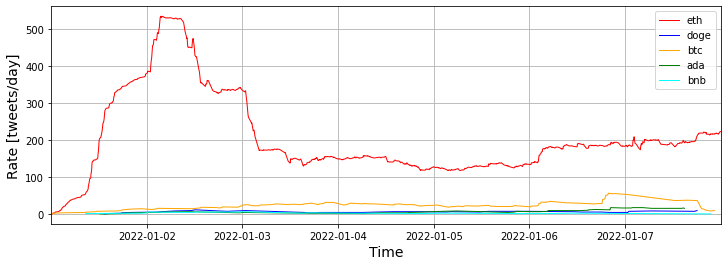

In [28]:
keywords = ['eth','doge','btc','ada','bnb']
colors = ['red','blue','orange','green','cyan']
fig = plt.figure(figsize = (12,4))

for color,keyword in zip(colors,keywords):
  df_plot = df[df.text.str.contains(keyword, case=False)].copy()
  df_plot['tweet_indicator'] = np.ones(len(df_plot))
  df_plot[f'rate_1D_{keyword}'] = df_plot.rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']

  sns.lineplot(data = df_plot, x = 'created_at_datetime',y = f'rate_1D_{keyword}',
                label = keyword,linewidth = 1,color = color)


plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
plt.xlim(ti,tf)
#plt.ylim([0,30])

plt.legend()
plt.show()

1529 tweets contain eth


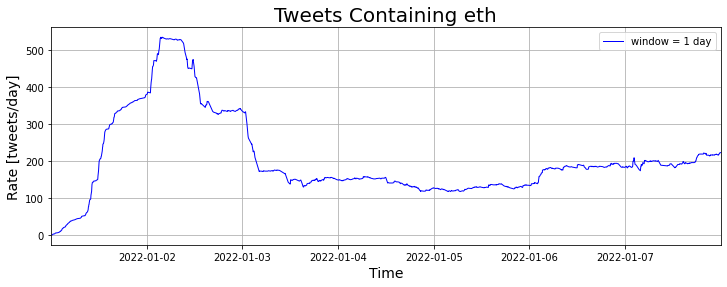

44 tweets contain doge


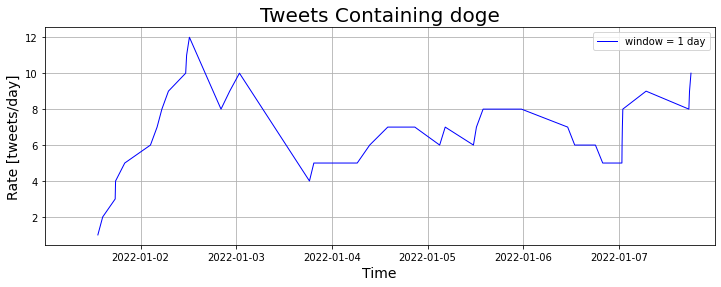

174 tweets contain btc


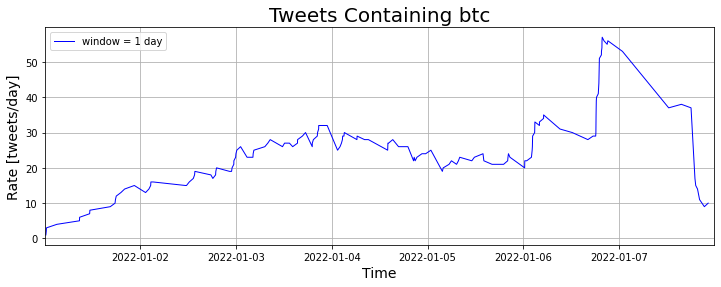

47 tweets contain ada


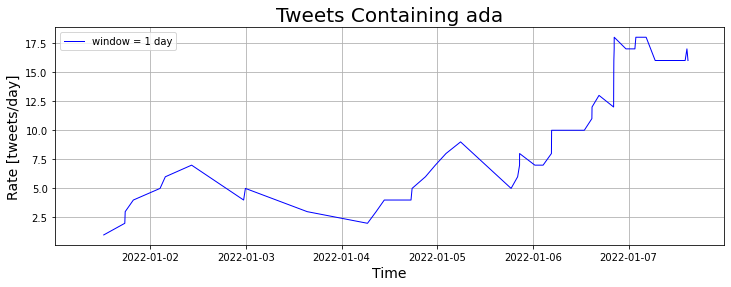

19 tweets contain bnb


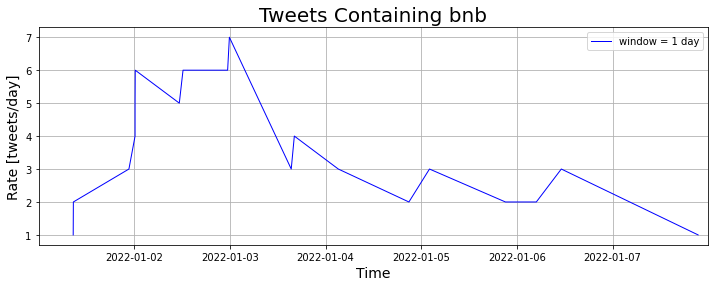

In [30]:
keywords = ['eth','doge','btc','ada','bnb']

for keyword in keywords:
    df_plot = df[df.text.str.contains(keyword, case=False)].copy()
    print(f"{len(df_plot)} tweets contain {keyword}")
    df_plot['tweet_indicator'] = np.ones(len(df_plot))
    df_plot[f'rate_1D_{keyword}'] = df_plot.rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']

    fig = plt.figure(figsize = (12,4))
    sns.lineplot(data = df_plot, x = 'created_at_datetime',y = f'rate_1D_{keyword}',
                 label = 'window = 1 day',linewidth = 1,color = 'blue')


    plt.grid()
    plt.xlabel("Time", fontsize = 14)

    plt.ylabel("Rate [tweets/day]", fontsize = 14)
    plt.xlim(ti,tf)
    #plt.ylim([0,30])
    plt.title(f"Tweets Containing {keyword}",fontsize = 20)

    plt.legend()
    plt.show()

## Find Tweets Containing at Least One Keyword

You may want to find tweets that contain at least one word from a list of keywords.  Define the keyword list `keywords`.  Then the code below will return a dataframe `df_keywords` that only has tweets with the keywords.

In [107]:
keywords = ['eth','btc']
df_keywords = df[df.text.str.contains('|'.join(keywords), flags=re.IGNORECASE)] 
print(f"df has {len(df)} tweets")
print(f"df_keywords has {len(df_keywords)} tweets")


df has 4805 tweets
df_keywords has 1587 tweets


## Interaction Network

### Build Interaction Network From Keyword Tweets

We can build an interaction network from the tweets in the `keyword_tweets` table using the function `interaction_network_from_tweets`.
The interaction network includes retweets, replies, and regular mentions of other users.  Our edge convention points to the person tweeting from the person being mentioned in the tweet. 

The user inputs are as follows:

1. `fname_db` = database filename where you stored the keyword tweets.  Do not add the `".db"` suffix.

2. `fname_interaction_network` = name of the file where you will save the interaction network.  Make sure it ends with `".pickle"`.

In [31]:
fname_db = "data/lecture_02"  #database filenmae
fname_interaction_network = 'data/lecture_02_interaction_network.pickle'


In [32]:
df_keyword= DB.fetch(table_name='keyword_tweets', path=fname_db)
G = interaction_network_from_tweets(df_keyword)
nx.write_gpickle(G, fname_interaction_network)



G has 2806 nodes and 3322 edges


### Draw Interaction Network

In [35]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 10
node_color = 'red'



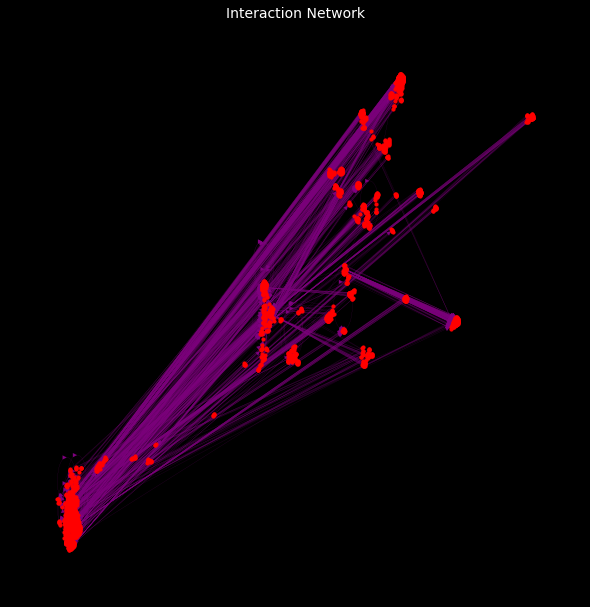

In [36]:
G = nx.read_gpickle(fname_interaction_network)

nv_max = 10000
nv = G.number_of_nodes()


pos_umap = umap_layout(G)

fig = plt.figure(figsize=(8,8))
nx.draw(G, pos_umap, node_color = node_color, 
        width= edge_width, 
        edge_color=edge_color,
        node_size=node_size,
        with_labels=False,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title("Interaction Network",color = 'white',fontsize = 14)
plt.show()
    


### Centrality calculation

We can look at the nodes with the highest network centralities.

In [57]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
EC = nx.eigenvector_centrality(G.reverse(),max_iter = 1000)  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G.to_undirected())  #undirected interation network works better for betweenness centrality

dictionary_list = []
for author_id in Din.keys():
    screen_name = G.nodes[author_id]['username']
    row = {'author_id':author_id,
           'screen_name':screen_name,
          'out_degree_centrality':Dout[author_id],
          'closeness_centrality':CC[author_id],
          'betweenness_centrality':BC[author_id],
          'eigenvector_centrality':EC[author_id],
          'in_degree_centrality':Din[author_id]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)


In [58]:
centrality = "closeness_centrality"
nmax = 10  #number of top screen names to display
df_centrality[['screen_name',centrality]].sort_values(by = [centrality],ascending = False).head(n=nmax)


,screen_name,closeness_centrality
3,BoredApeYC,0.137655
8,opensea,0.054833
57,rarible,0.041711
1021,TrillonaireNFTs,0.037790
141,Eminem,0.018424
940,WhaleCoinTalk,0.009982
332,BACryptoPaint,0.008926
390,garyvee,0.007254
364,BoredApeBC,0.006079
275,apocalypticapes,0.006061


out_degree_centrality
closeness_centrality
betweenness_centrality
eigenvector_centrality
in_degree_centrality


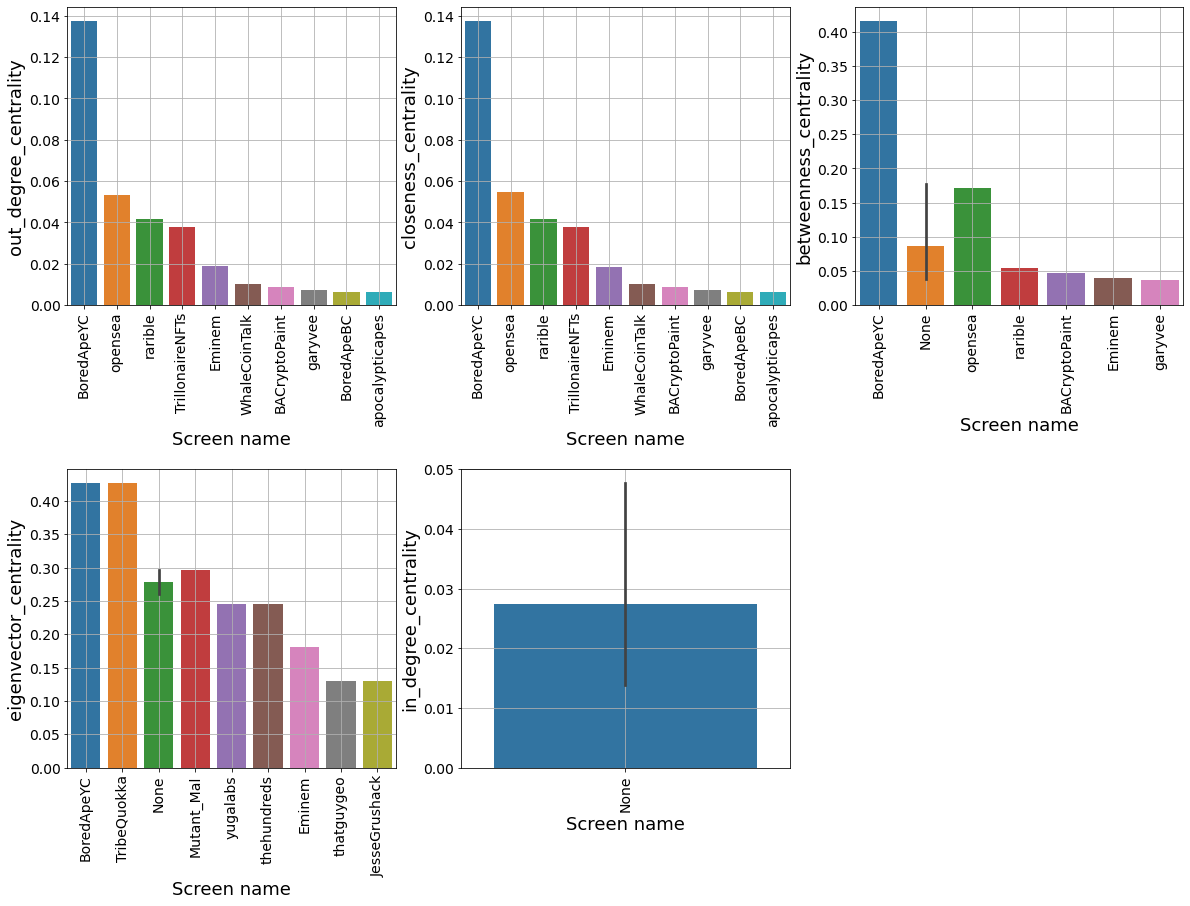

In [59]:
Centrality_names = df_centrality.columns.tolist()[2:]
nmax = 10  #number of top screen names to plot


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):  
    print(centrality_name)  
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False)  #sort dataframe by centrality value
    plt.subplot(2,3,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    
    ax = sns.barplot(data = df_plot[0:kmax], x='screen_name', y=centrality_name)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylabel(f"{centrality_name}",fontsize = 18)
    plt.xlabel('Screen name',fontsize = 18)
    plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.55)

plt.show()

## Similarity Network

### Build Similarity Network

We can build a similarity network from the interaction network.  In this network there is an edge between a pair of nodes of their similarity exceeds a minimum threshold.  For similarity, we use a measure called the Jaccard Coefficient (https://en.wikipedia.org/wiki/Jaccard_index).  The similarity network is useful for finding communities.

The user inputs are as follows:

1. `fname_interaction_network` = name of the file where you saved the interaction network.  Make sure it ends with `".pickle"`.

2. `fname_similarity_network` = name of the file where you will save the similarity network.  Make sure it ends with `".pickle"`.

3. `ne_max` = the maximum number of edges in the similarity network

4. `jmin` = minimum value of jaccard coefficient of an edge in order to keep it in the similarity network

In [60]:
fname_interaction_network = 'data/lecture_02_interaction_network.pickle'
fname_similarity_network = 'data/lecture_02_similarity_network.pickle'

ne_max = 1e7  #max number of edges in network
jmin = 0.5  #minimum value of jaccard coefficient to keep in network

In [61]:
%%time
G = nx.read_gpickle(fname_interaction_network)

Gsim = nx.Graph()
preds = nx.jaccard_coefficient(G.to_undirected())
ne=0
for c, x in enumerate(preds):
    if x[2]>jmin:
        Gsim.add_edge(x[0],x[1],weight=x[2])
        ne+=1
    if c%1e6==0:
        print(f"node pair {c}, {ne} edges formed in similarity network")
    if ne>ne_max:break

print(f"Similarity network has {Gsim.number_of_nodes()} nodes and {Gsim.number_of_edges()} edges over {c} node pairs")


node pair 0, 0 edges formed in similarity network
node pair 1000000, 13844 edges formed in similarity network
node pair 2000000, 27696 edges formed in similarity network
node pair 3000000, 41208 edges formed in similarity network
Similarity network has 1829 nodes and 52985 edges over 3932142 node pairs
CPU times: user 57.2 s, sys: 149 ms, total: 57.3 s
Wall time: 57.9 s


In [62]:
#save similarity network
nx.write_gpickle(Gsim, fname_similarity_network)


### Find Modularity Communities Using Similarity Network

We can find the modularity communities in the similarity network and plot their sizes.

In [ ]:
Gsim = nx.read_gpickle(fname_similarity_network)


In [80]:

Comm = nx_comm.greedy_modularity_communities(Gsim.to_undirected())
C = []
V = []
for count,comm in enumerate(Comm):
    for v in comm:
        C.append(count)
        V.append(v)
        
df_mod = pd.DataFrame({'screen_name':V, 'community':C})
ncomm_mod = len(df_mod.community.unique())
print(f"{ncomm_mod} modularity communities")

243 modularity communities


### Find Spectral Communities Using Similarity Network

We can find the spectral communities in the similarity network and plot their sizes.  Spectral is nicer because we can choose how many communities we want.

In [86]:
k = 4
df_spec = spectral_communities(Gsim,k)

ncomm_spec = len(df_spec.community.unique())
print(f"{ncomm_spec} spectral communities")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


4 spectral communities


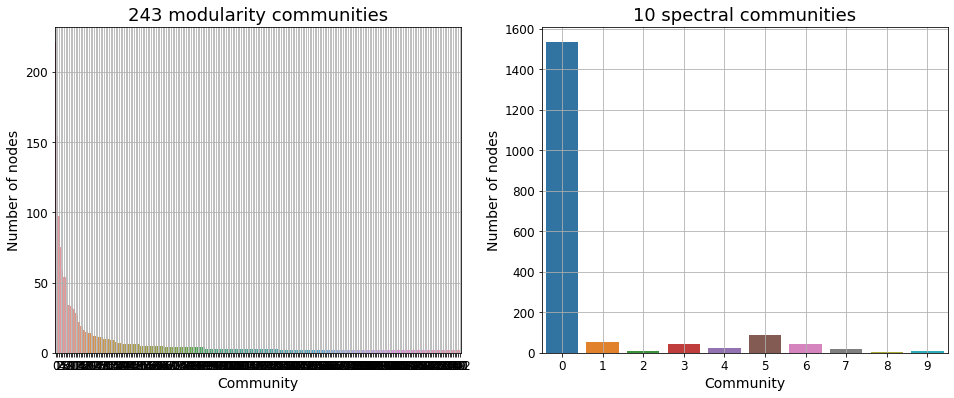

In [85]:
#plot modularity community sizes
fig = plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
ax = sns.countplot(data=df_mod, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_mod} modularity communities", fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()


#plot spectral community sizes
plt.subplot(1,2,2)
ax = sns.countplot(data=df_spec, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_spec} spectral communities", fontsize = 18)
plt.grid()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### Draw Similarity Network with Community Colors

In [89]:
#Colors = ['blue','orange','green','red']
Colors = [np.random.uniform(0,1,3) for _ in range(10000)]

node_color_spec = [Colors[df_spec.community[df_spec.screen_name==node].values[0]] for node in df_spec.screen_name]
node_color_mod = [Colors[df_mod.community[df_mod.screen_name==node].values[0]] for node in df_mod.screen_name]


In [73]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 10

In [74]:
%time pos_umap_sim = umap_layout(Gsim)

CPU times: user 33.6 s, sys: 213 ms, total: 33.8 s
Wall time: 25.6 s


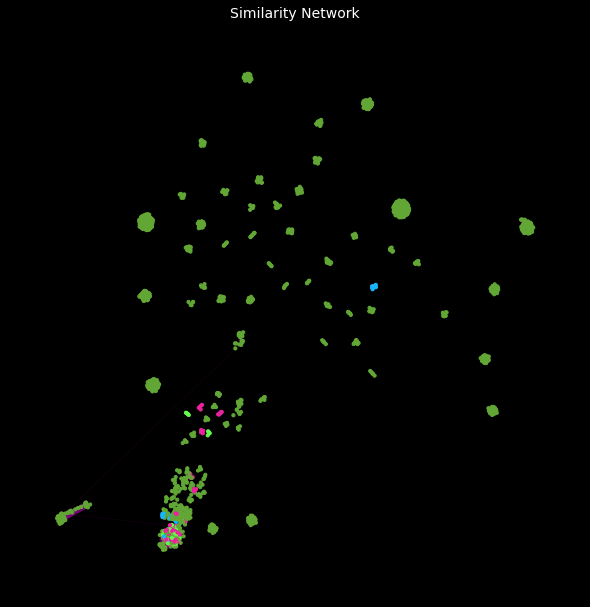

CPU times: user 1.44 s, sys: 109 ms, total: 1.55 s
Wall time: 1.56 s


In [93]:
%%time
nv = Gsim.number_of_nodes()

fig = plt.figure(figsize=(8,8))
nx.draw(Gsim, pos_umap_sim, node_color = node_color_spec, 
        width= edge_width, 
        edge_color=edge_color,
        node_size=node_size,
        with_labels=False,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title("Similarity Network",color = 'white',fontsize = 14)
plt.show()
    


### Wordcloud Tweets in Each Community

In [97]:
stopwords = set(STOPWORDS)
stopwords.add("boredapeyachtclub")
stopwords.add("nft")

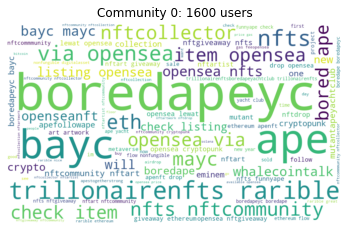

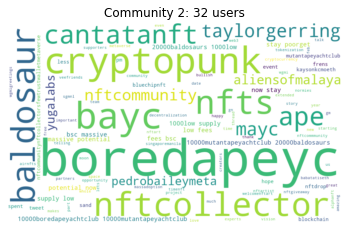

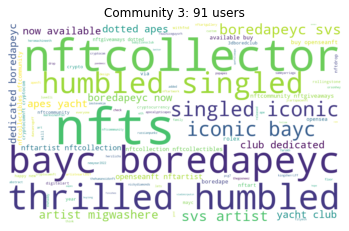

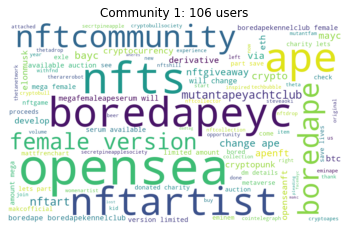

In [98]:
for community in df_spec.community.unique():
    V = df_spec.screen_name[df_spec.community==community].tolist()

    df1 = df[df.author_id.isin(V)]

    text=' '.join(df1.text_clean.tolist()).lower()

    wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
    wordcloud.generate(text)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Community {community}: {len(V)} users")
    plt.axis("off")
    plt.show()

In [99]:
keywords = ['dogecointothemoon','dogearmy']
df_keywords = df[df.text.str.contains('|'.join(keywords), flags=re.IGNORECASE)] 
print(f"df has {len(df)} tweets")
print(f"df_keywords has {len(df_keywords)} tweets")
